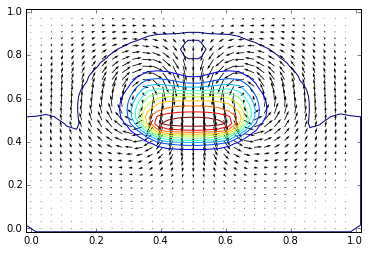

99


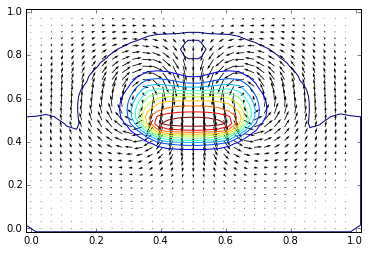

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
%matplotlib inline

#domain size and physical variables
Lx=1.0
Ly=1.0
gx=0.0
gy=-100.0
rho1=1.0
rho2=2.0
m0=0.01

#tangential velocities
unorth=0
usouth=0.
veast=0.
vwest=0.

#Initial drop size and location
rad=0.15 
xc=0.5
yc=0.7

#Numerical variables
nx=32
ny=32
dt=0.00125
nstep=100
maxiter=200
maxError=0.001
beta=1.2

u=np.zeros((nx+1,ny+2))
v=np.zeros((nx+2,ny+1))
p=np.zeros((nx+2,ny+2))

ut=np.zeros((nx+1,ny+2))
vt=np.zeros((nx+2,ny+1))

#temp variables for pressure calculations
tmp1=np.zeros((nx+2,ny+2))
tmp2=np.zeros((nx+2,ny+2))

#velocities at center of grid for plotting
uu=np.zeros((nx+1,ny+1))
vv=np.zeros((nx+1,ny+1))

#Define the grid
dx=Lx/(nx) 
dy=Ly/(ny)

x=np.linspace(-0.5*dx,(nx+.5)*dx,nx+2)
y=np.linspace(-0.5*dy,(ny+.5)*dy,nx+2)

r=np.ones((nx+2,ny+2))*rho1

#Set initial conditions for density
for i in range(1,nx+1):
    for j in range(1,ny+1):
        if ((x[i]-xc)**2+(y[j]-yc)**2)<rad**2:
            r[i,j]=rho2
        
time=0.
for steps in range(nstep):

    #tangential velocity at boundaries
    u[:,0]=2.*usouth-u[:,1]
    u[:,-1]=2.*unorth-u[:,-2]
    v[0,:]=2.*vwest-v[1,:]
    v[-1,:]=2.*veast-v[-2,:]
    
    # TEMPORARY u-velocity                               
    for i in range(1,nx):
        for j in range(1,ny+1):
            ut[i,j]=u[i,j]+dt*(-0.25*(((u[i+1,j]+u[i,j])**2-(u[i,j]+\
                u[i-1,j])**2)/dx+((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                v[i,j])-(u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1]))/dy)+\
                m0/(0.5*(r[i+1,j]+r[i,j]))*((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2+\
                (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2 )+gx)

    # TEMPORARY v-velocity                               
    for i in range(1,nx+1):
        for j in range(1,ny):
            vt[i,j]=v[i,j]+dt*(-0.25*(((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                v[i,j])-(u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j]))/dx+\
                ((v[i,j+1]+v[i,j])**2-(v[i,j]+v[i,j-1])**2)/dy)+\
                m0/(0.5*(r[i,j+1]+r[i,j]))*((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2+\
                (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2 )+gy)    


    #Compute source term and the coefficient for p(i,j)
    rt=r.copy()
    lrg=1000.
    rt[:,0]=lrg
    rt[:,-1]=lrg
    rt[0,:]=lrg
    rt[-1,:]=lrg
    
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            tmp1[i,j]= (0.5/dt)*( (ut[i,j]-ut[i-1,j])/dx+(vt[i,j]-vt[i,j-1])/dy)
            tmp2[i,j]=1.0/( (1./dx)*( 1./(dx*(rt[i+1,j]+rt[i,j]))+\
                1./(dx*(rt[i-1,j]+rt[i,j])))+\
                (1./dy)*(1./(dy*(rt[i,j+1]+rt[i,j]))+\
                1./(dy*(rt[i,j-1]+rt[i,j])))) 

    iter=0
    while True:
        pn=p.copy()
        iter=iter+1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                    (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                    p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                    (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                    p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])
        if np.abs(pn-p).max()<maxError:
            break
        if iter>maxiter:
            break
            
    #CORRECT THE u-velocity
    for i in range(1,nx):
        for j in range(1,ny+1):
            u[i,j]=ut[i,j]-dt*(2.0/dx)*(p[i+1,j]-p[i,j])/(r[i+1,j]+r[i,j])
    
    #CORRECT THE v-velocity
    for i in range(1,nx+1):
        for j in range(1,ny):
            v[i,j]=vt[i,j]-dt*(2.0/dy)*(p[i,j+1]-p[i,j])/(r[i,j+1]+r[i,j])


#=======ADVECT DENSITY using centered difference plus diffusion ==========
    ro=r.copy()
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            r[i,j]=ro[i,j]-(0.5*dt/dx)*(u[i,j]*(ro[i+1,j]\
                    +ro[i,j])-u[i-1,j]*(ro[i-1,j]+ro[i,j]))\
                    -(0.5* dt/dy)*(v[i,j]*(ro[i,j+1]\
                    +ro[i,j])-v[i,j-1]*(ro[i,j-1]+ro[i,j]))\
                    +(m0*dt/dx/dx)*(ro[i+1,j]-2.0*ro[i,j]+ro[i-1,j])\
                    +(m0*dt/dy/dy)*(ro[i,j+1]-2.0*ro[i,j]+ro[i,j-1])
                    
    time=time+dt
    #Plot the density contour and the velocity field
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
    yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
    plt.clf()
    plt.quiver(xx,yy,uu.T,vv.T)
    plt.contour(x,y,r.T,10)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print steps    